# Network Optimization
    Optimizing a network's virtual backbone using Graph Theory

## Import Tools

### Import Graph Tool Modules
    Specifically graph_tool main, draw and collection modules

In [63]:
import graph_tool.all
import graph_tool as gt
import graph_tool.draw
import graph_tool.collection

### Import Other Required Modules
    These Modules include Matplotlib

In [64]:
import matplotlib as mpl

In [65]:
%matplotlib inline

In [66]:
import _pickle as pickle

In [67]:
from tqdm import tqdm_notebook as tqdm

In [68]:
from enum import Enum

## Algorithms

### Exact Exponential Algorithms

#### Minimum Dominating Set
    A bitmask approach to compute the minimum dominating set of a graph

In [69]:
def min_dominating_set_e1(graph):
    vertices = list(graph.vertices())
    vertex_neighbours_dict = {}

    for vertex in graph.vertices():
        vertex_neighbours = set(vertex.out_neighbors())
        vertex_neighbours.add(vertex)
        vertex_neighbours_dict[vertex] = vertex_neighbours

    min_dominating_set = set(vertices)

    for i in tqdm(range(2**(len(vertices)))):
        dominated = set()
        dominating = set()
        for j in range(len(vertices)):
            if not i&(1<<j):
                continue
            dominating.add(vertices[j])
            if len(dominating) >= len(min_dominating_set):
                break
            dominated = dominated.union(vertex_neighbours_dict[vertices[j]])
            if len(dominated) == len(vertices):
                min_dominating_set = dominating
                break
    
    dominated_property_map = graph.new_vertex_property("bool")
    dominated_property_map.set_value(0)
    for vertex in min_dominating_set:
        dominated_property_map[vertex] = 1
    
    return dominated_property_map

In [70]:
def min_dominating_set_e2(graph):
#https://ac.els-cdn.com/S0166218X11002393/1-s2.0-S0166218X11002393-main.pdf?_tid=2f975e0a-6fcd-4926-a7ac-f93b6265cf0a&acdnat=1534822962_d706d676ada4b2561924be5cb7565e4a

   

    vertices = graph.vertices()

    dominated_set = set()

    dominating_set = set()

    vertex_neighbours_dict = {}

    frequency_dict = {}

    # the set of vertices that dont need to be checked for dominater
    ignore_vertices = set()

    # the set of vertices that dont need to be checked 
    invisible_vertices = set()

    for vertex in graph.vertices():
        vertex_neighbours = set(vertex.out_neighbors())
        vertex_neighbours.add(vertex)
        vertex_neighbours_dict[vertex] = vertex_neighbours

    for vertex in graph.vertices():
        vertex_neighbours = set(vertex.out_neighbors())
        frequency_dict[vertex] = vertex_neighbours

    for vertex in vertex_neighbours_dict.keys():
        if len(set(vertex.out_neighbours())) == 1:
            dominated_set.add(vertex)
            dominating_set = dominating_set.union(set(vertex.out_neighbours()))

    for v,n in vertex_neighbours_dict.items():
        if v in ignore_vertices:
            continue
        for vertex, neighbours in vertex_neighbours_dict.items():
            if vertex == v:
                continue
            if neighbours.issubset(n):
                ignore_vertices.add(vertex)



    for vertex, neighbours in vertex_neighbours_dict.items():
        if vertex in invisible_vertices:
            continue
        neighbour_intersection = set()
        neighbour_intersection = neighbour_intersection.union(neighbours)
        for neighbour in neighbours:
            neighbour_intersection = neighbour_intersection.intersection(neighbour.out_neighbours())
        invisible_vertices = invisible_vertices.union(neighbour_intersection)

    frequency_2_vertices = set()

    for vertex, neighbours in frequency_dict.items():
        if len(neighbours) == 2:
            frequency_2_vertices.add(vertex)

    must_take_dominaters = set()
    pre_dominated = set()

    for vertex, neighbours in vertex_neighbours_dict.items():
        if vertex in pre_dominated:
            continue
        frequency_2_neighbours = neighbours.intersection(frequency_2_vertices)
        q = 0
        for v, n in vertex_neighbours_dict.items():
            if v == vertex:
                continue
            common_2_frequency = frequency_2_neighbours.intersection(n)
            if common_2_frequency:
                q += len(n) - len(common_2_frequency)
        if q < len(neighbours):
            must_take_dominaters.add(vertex)
            pre_dominated = pre_dominated.union(vertex_neighbours_dict[vertex])

    return ignore_vertices, invisible_vertices, must_take_dominaters, pre_dominated

#### Minimum Connected Dominating Set
    A bitmask approach to compute the minimum connected dominating set of a graph

In [71]:
def min_connected_dominating_set_e1(graph):
    vertices = list(graph.vertices())
    vertex_neighbours_dict = {}

    for vertex in graph.vertices():
        vertex_neighbours = set(vertex.out_neighbors())
        vertex_neighbours.add(vertex)
        vertex_neighbours_dict[vertex] = vertex_neighbours

    min_dominating_set = set(vertices)

    for i in tqdm(range(2**(len(vertices)))):
        dominated = set()
        dominating = set()
        for j in range(len(vertices)):
            if not i&(1<<j):
                continue
            if j>0 and not vertices[j] in dominated:
                continue
                
            dominating.add(vertices[j])
            
            if len(dominating) >= len(min_dominating_set):
                break
            dominated = dominated.union(vertex_neighbours_dict[vertices[j]])
            if len(dominated) == len(vertices):
                min_dominating_set = dominating
                break
    
    dominated_property_map = graph.new_vertex_property("bool")
    dominated_property_map.set_value(0)
    for vertex in min_dominating_set:
        dominated_property_map[vertex] = 1
    
    return dominated_property_map

### Heuristic Approximate Algorithms

#### Minimum Dominating Set
    A Greedy approach for computing the minimum dominating set of an undirected graph

In [72]:
def helper_min_dominating_set_h1(graph):
#     import pdb; pdb.set_trace()
    dominated_set = set()
    dominating_set = set()
    vertex_neighbours_dict = {}
#     total_vertices = len(graph.vertices())
    
    for vertex in graph.vertices():
        vertex_neighbours = set(vertex.out_neighbors())
        vertex_neighbours.add(vertex)
        vertex_neighbours_dict[vertex] = vertex_neighbours
    
#     print(vertex_neighbours_dict)
    
    def get_max_potential_vertex():
        max_potential = 0
        max_p_vertex = None
        for vertex, neighbours in vertex_neighbours_dict.items():
            if len(neighbours) > max_potential:
                max_potential = len(neighbours)
                max_p_vertex = vertex
        return max_p_vertex
    
    while vertex_neighbours_dict:
        current_vertex = get_max_potential_vertex()
#         print("The current vertex is", current_vertex)
#         print("The current dominated set is", dominated_set)
#         print("The neighbours not dominated yet for the current vertex is", vertex_neighbours_dict[current_vertex])
        current_vertex_neighbours = vertex_neighbours_dict.pop(current_vertex, None)
#         print("Recheck", current_vertex_neighbours)
        dominated_set = dominated_set.union(current_vertex_neighbours)
        dominating_set.add(current_vertex)
        to_delete = set()
        for vertex, neighbours in vertex_neighbours_dict.items():
            neighbours = neighbours.difference(current_vertex_neighbours)
            vertex_neighbours_dict[vertex] = neighbours
            if not neighbours:
                to_delete.add(vertex)
        for vertex in to_delete:
            vertex_neighbours_dict.pop(vertex)
        
    return dominating_set    

In [73]:
def min_dominating_set_h1(graph):
    dominating_set = helper_min_dominating_set_h1(graph)
    dominated_property_map = graph.new_vertex_property("bool")
    dominated_property_map.set_value(0)
    for vertex in dominating_set:
        dominated_property_map[vertex] = 1
    
    return dominated_property_map
        

#### Minimum Connected Dominating Set
    A Greedy approach to compute the minimum connected dominating set of a graph

In [74]:
def helper_min_connected_dominating_set_h1(graph):
    dominated_set = set()
    dominating_set = set()
    vertex_neighbours_dict = {}
    possible_vertex_options = set()
    
    for vertex in graph.vertices():
        vertex_neighbours = set(vertex.out_neighbors())
        vertex_neighbours.add(vertex)
        vertex_neighbours_dict[vertex] = vertex_neighbours
    
    
    def get_max_potential_vertex(iterable):
        max_potential = 0
        max_p_vertex = None
        for vertex in iterable:
            neighbours = vertex_neighbours_dict.get(vertex, [])
            if len(neighbours) > max_potential:
                max_potential = len(neighbours)
                max_p_vertex = vertex
        return max_p_vertex
    
    first_vertex = get_max_potential_vertex(vertex_neighbours_dict.keys())
    possible_vertex_options.add(first_vertex)
    
    
    
    while possible_vertex_options:
        current_vertex = get_max_potential_vertex(possible_vertex_options)
        if not current_vertex:
            break
        possible_vertex_options.remove(current_vertex)
        to_delete = set()
        current_vertex_neighbours = vertex_neighbours_dict.pop(current_vertex, set())
        possible_vertex_options = possible_vertex_options.union(current_vertex_neighbours)
        dominated_set = dominated_set.union(current_vertex_neighbours)
        dominating_set.add(current_vertex)
        for vertex, neighbours in vertex_neighbours_dict.items():
            neighbours = neighbours.difference(current_vertex_neighbours)
            vertex_neighbours_dict[vertex] = neighbours
            if not neighbours:
                to_delete.add(vertex)
        for vertex in to_delete:
            vertex_neighbours_dict.pop(vertex)
        

    return dominating_set
    

In [75]:
def min_connected_dominating_set_h1(graph):
    dominating_set = helper_min_connected_dominating_set_h1(graph)
    dominated_property_map = graph.new_vertex_property("bool")
    dominated_property_map.set_value(0)
    for vertex in dominating_set:
        dominated_property_map[vertex] = 1
    
    return dominated_property_map


### Miscellaneous Algorithms

In [76]:
#### Convert set to property map

In [104]:
def get_map(graph, function):
    dominating_set = function(graph)
    dominated_property_map = graph.new_vertex_property("bool")
    dominated_property_map.set_value(0)
    print(len(dominating_set))
    for vertex in dominating_set:
        dominated_property_map[vertex] = 1
    
    return dominated_property_map

#### Algorithm to check for Unique Dominating Set

In [78]:
# inputs: graph, dominating set
# for each vertex in the graph, find its neighbours in the dominating set
# for vertices (not belonging to the dominating set) with a single neighbour in the Dominating Set, update the corresponding neighbour
# check whether all vertices of the dominating set have atleast 2 updates
# return condition

In [79]:
def check_unique_dominating_set(graph, dominating_set):
    
    vertices = set(graph.vertices())
    dominated_vertices = vertices.difference(set(dominating_set))
    count = {}
    for v in dominating_set:
        count[v] = 0
    for v in dominated_vertices:
        neighbours = set(v.out_neighbours())
        dominators = list(neighbours.intersection(dominating_set))
        if len(dominators) == 1:
            count[dominators[0]] += 1
    
    for k,v in count.items():
        if v<2:
            return False
    
    return True

### Helper Tool

In [80]:
class Algorithms(Enum):
    MIN_DOMINATING_SET =1
    MIN_CONNECTED_DOMINATING_SET =2
    MIN_WEIGHT_DOMINATING_SET =3
    MIN_WEIGHT_CONNECTED_DOMINATING_SET =4
    PENALTY_DOMINATING_SET =5

In [81]:
def compute(graph, algorithm, exact=False):
    
    if exact:
        return Exact.compute(graph, algorithm)
    if not exact:
        return Heuristic.compute(graph, algorithm)
    

In [82]:
class Exact:
    
    algorithm_dict = {}
    algorithm_dict[Algorithms.MIN_CONNECTED_DOMINATING_SET] = min_connected_dominating_set_e1
    algorithm_dict[Algorithms.MIN_DOMINATING_SET] = min_dominating_set_e1
    def compute(graph, algorithm):
        return Exact.algorithm_dict[algorithm](graph)

In [83]:
class Heuristic:
    
    algorithm_dict = {}
    algorithm_dict[Algorithms.MIN_CONNECTED_DOMINATING_SET] = min_connected_dominating_set_h1
    algorithm_dict[Algorithms.MIN_DOMINATING_SET] = min_dominating_set_h1
    algorithm_dict[Algorithms.PENALTY_DOMINATING_SET] = computeUnoptimise
    def compute(graph, algorithm):
        return Heuristic.algorithm_dict[algorithm](graph)

In [84]:
class ConstantFactor:
    pass

In [85]:
class Genetic:
    pass

In [86]:
class ArtificialBeeColony:
    pass

## Sample Graphs

### Library Collections

#### List of available graphs

In [98]:
list(gt.collection.data.keys())

['adjnoun',
 'as-22july06',
 'astro-ph',
 'celegansneural',
 'cond-mat',
 'cond-mat-2003',
 'cond-mat-2005',
 'dolphins',
 'email-Enron',
 'football',
 'hep-th',
 'karate',
 'lesmis',
 'netscience',
 'pgp-strong-2009',
 'polblogs',
 'polbooks',
 'power',
 'serengeti-foodweb']

##### Visualise Graph

In [99]:
# select graph from library collection
graph = gt.collection.data["football"]

In [100]:
# uniform position 
pos = gt.draw.sfdp_layout(graph)

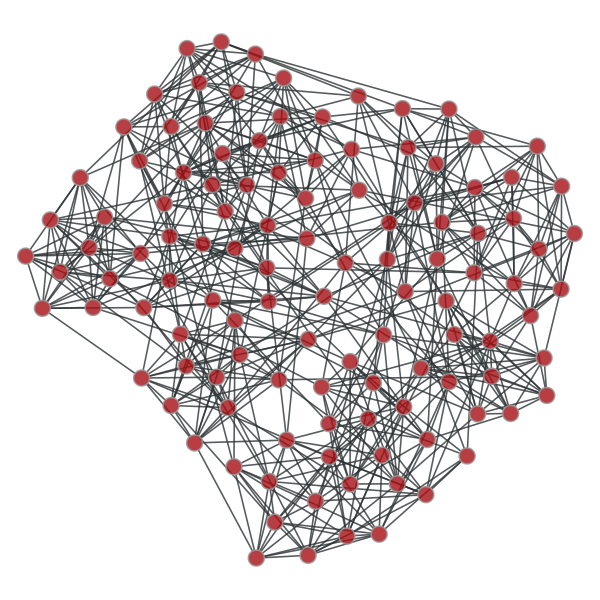

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x1330af748, at 0x133814048>

In [101]:
gt.draw.graph_draw(graph, pos=pos)

##### Minimum Dominating Set

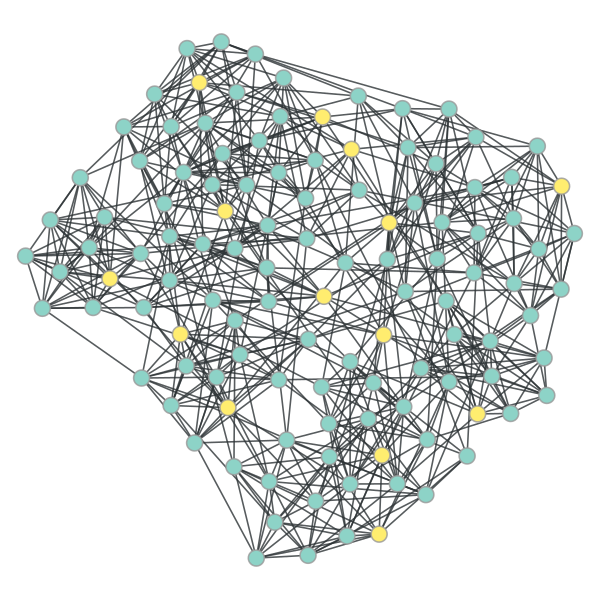

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x1330af748, at 0x133814048>

In [102]:
gt.draw.graph_draw(graph, vertex_fill_color=compute(graph, Algorithms.MIN_DOMINATING_SET, exact=False ), pos=pos)

##### Minimum Connected Dominating Set

0
1
2
3
4
5
6
7
8
9
10
11
12


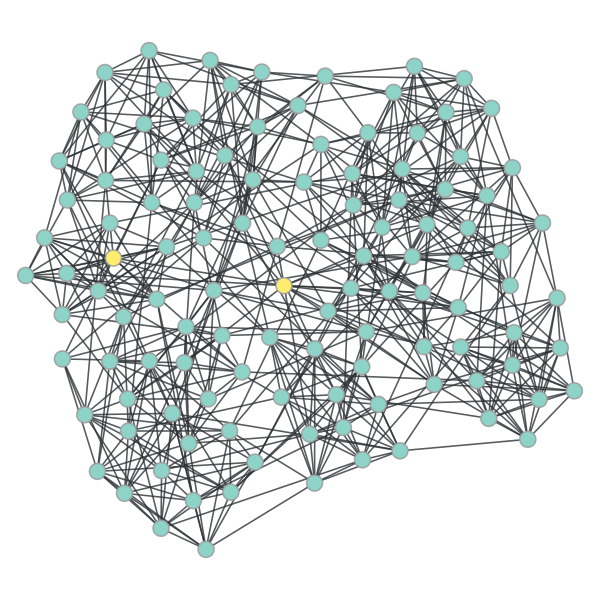

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x1330af748, at 0x1330c10b8>

In [103]:
gt.draw.graph_draw(graph, vertex_fill_color=compute(graph, Algorithms.PENALTY_DOMINATING_SET, exact=False ))

### Custom Graphs

#### Lattice Graph

##### Visualize Graph

In [89]:
graph = gt.generation.lattice([5,5,5], periodic=False)

In [137]:
pos = gt.draw.sfdp_layout(graph)

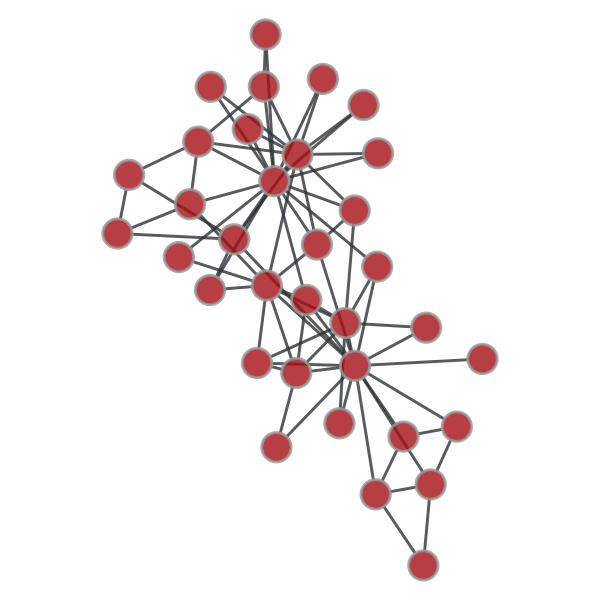

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x133838898, at 0x1381a0b70>

In [138]:
gt.draw.graph_draw(graph, pos=pos)

##### Minimum Dominating Set

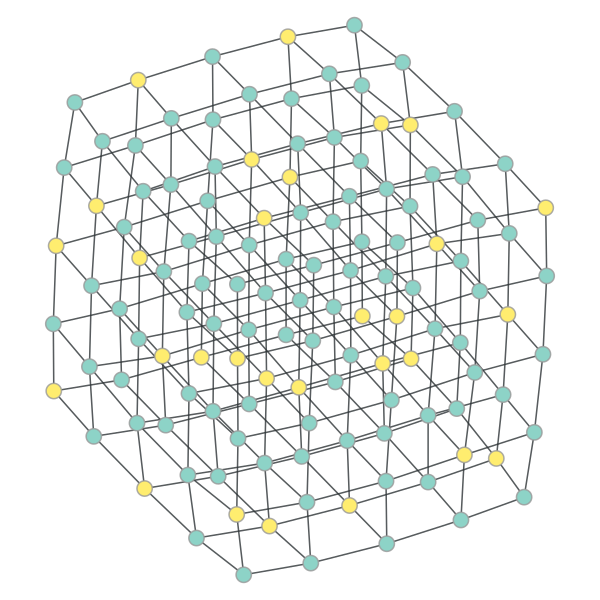

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x1338211d0, at 0x133821e80>

In [95]:
gt.draw.graph_draw(graph, pos=pos, vertex_fill_color=compute(graph, Algorithms.MIN_DOMINATING_SET, exact=False ) )

##### Minimum Connected Dominating Set

In [107]:
gt.draw.graph_draw(graph, pos=pos, vertex_fill_color=compute(graph, Algorithms.PENALTY_DOMINATING_SET, exact=False ))

12


TypeError: object of type 'PropertyMap' has no len()

12


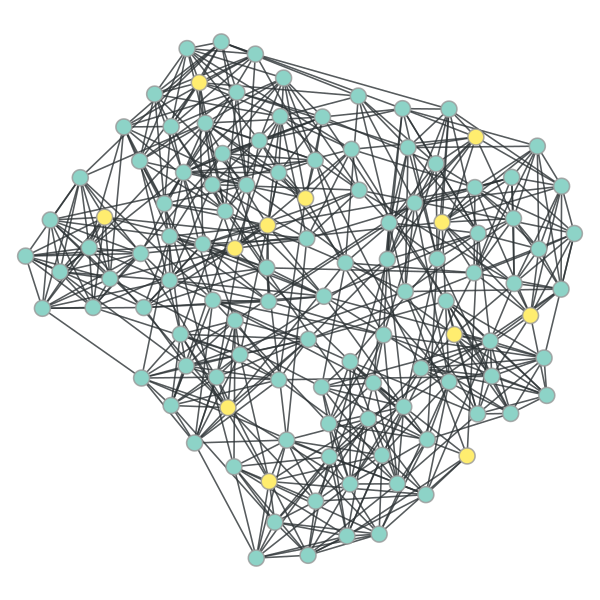

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x1330af748, at 0x133814048>

In [110]:
gt.draw.graph_draw(graph, pos=pos, vertex_fill_color=computeUnoptimise(graph))

#### Random Graph

In [75]:
# limit 10
from random import random as random_number
def random_degree_sampler():
    return int((random_number()*10) +1)

##### Visualize Graph

In [76]:
graph = gt.generation.random_graph(N=200, deg_sampler=random_degree_sampler, directed=False, verbose=True )

In [77]:
pos = gt.draw.sfdp_layout(graph)

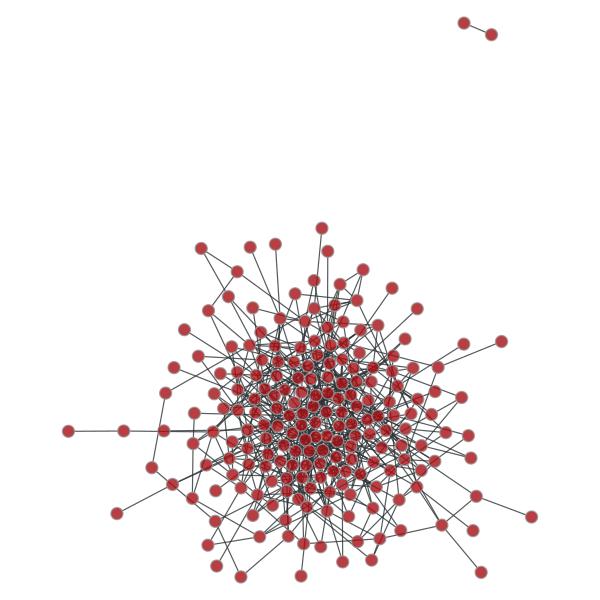

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x10ae83160, at 0x10ae97b70>

In [78]:
gt.draw.graph_draw(graph, pos=pos)

##### Minimum Dominating Set

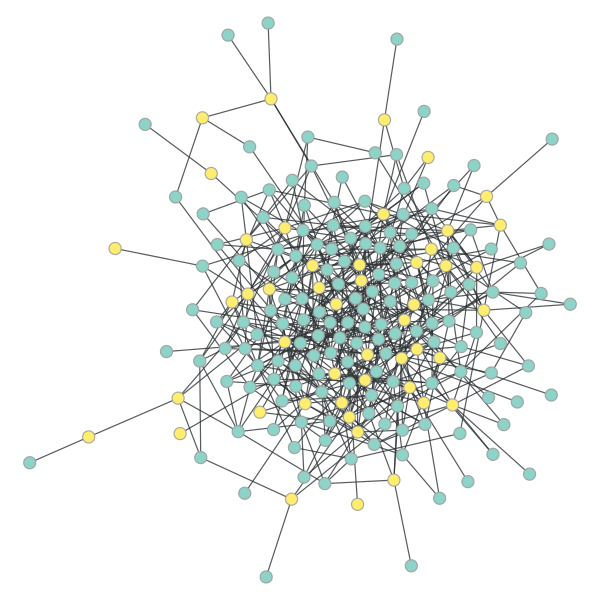

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x132741518, at 0x132741240>

In [40]:
gt.draw.graph_draw(graph, pos=pos, vertex_fill_color=compute(graph, Algorithms.MIN_DOMINATING_SET, exact=False ))

##### Minimum Connected Dominating Set

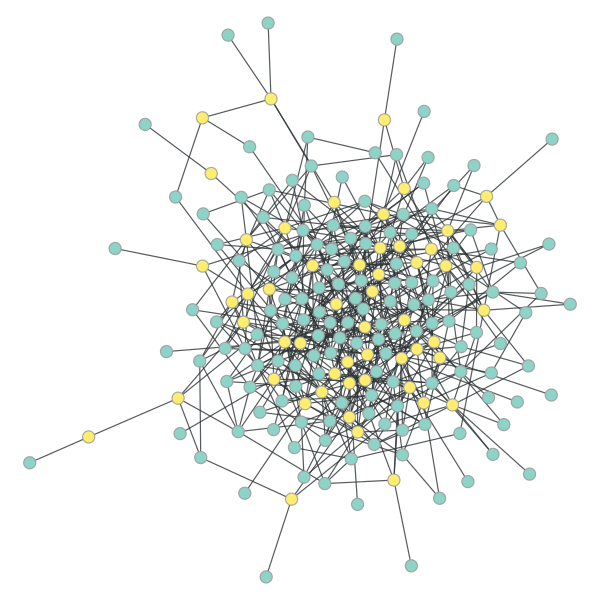

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x132741518, at 0x132741240>

In [41]:
gt.draw.graph_draw(graph, pos=pos, vertex_fill_color=compute(graph, Algorithms.MIN_CONNECTED_DOMINATING_SET, exact=False ))

#### Circular Graph

##### Visualize Graph

In [42]:
graph = gt.generation.circular_graph(N=24, directed=False, k=1)

In [43]:
pos = gt.draw.sfdp_layout(graph)

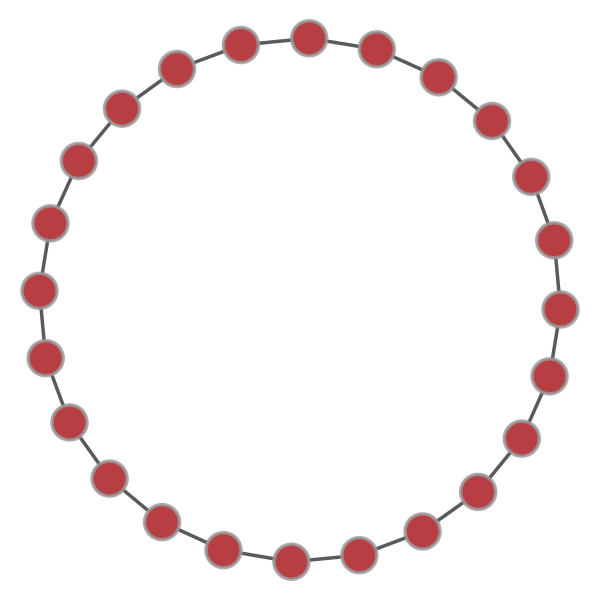

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x132741128, at 0x132741358>

In [44]:
gt.draw.graph_draw(graph, pos=pos)

##### Minimum Dominating Set

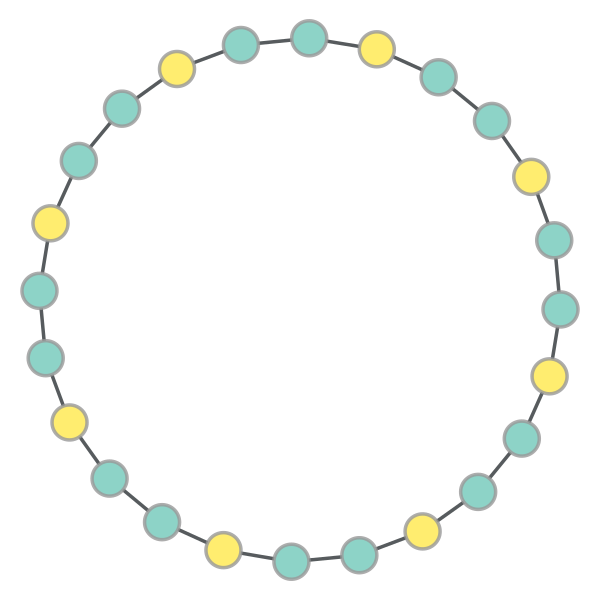

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x132741128, at 0x132741358>

In [45]:
gt.draw.graph_draw(graph, pos=pos, vertex_fill_color=compute(graph, Algorithms.MIN_DOMINATING_SET, exact=False ))

In [46]:
# gt.draw.GraphWidget(graph, pos=pos, vertex_fill_color=min_dominating_set(graph))

##### Minimum Connected Dominating Set

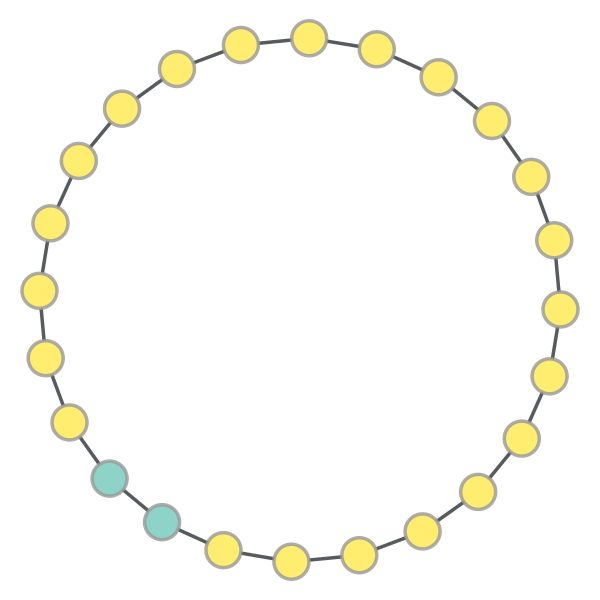

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x132741128, at 0x132741358>

In [47]:
gt.draw.graph_draw(graph, pos=pos, vertex_fill_color=compute(graph, Algorithms.MIN_CONNECTED_DOMINATING_SET, exact=False ))

#### Triangular Graph

In [48]:
# with open('simple_triangular_undirected_graph.pickle', 'wb') as f:
#     pickle.dump(graph, f)

In [49]:
with open('simple_triangular_undirected_graph.pickle', 'rb') as f:
    graph = pickle.load(f)

In [ ]:
gt.draw.graph_draw(graph, vertex_text=graph.vertex_index)

### Counter Example Graphs

#### Greedy Heuristic Algorithms

In [29]:
# with open('counter_example_greedy_heuristic.pickle', 'wb') as f:
#     pickle.dump(save_counter_example_graph_1, f)

In [30]:
with open('counter_example_greedy_heuristic.pickle', 'rb') as f:
    graph = pickle.load(f)

In [31]:
pos = gt.draw.sfdp_layout(graph)

In [ ]:
gt.draw.graph_draw(graph,  vertex_text=graph.vertex_index, pos=pos)

##### Approximate Algorithm Results

In [ ]:
gt.draw.graph_draw(graph, vertex_fill_color=compute(graph, Algorithms.MIN_DOMINATING_SET, exact=False ), vertex_text=graph.vertex_index, pos=pos)

In [ ]:
gt.draw.graph_draw(graph,vertex_fill_color=compute(graph, Algorithms.MIN_CONNECTED_DOMINATING_SET, exact=False ), vertex_text=graph.vertex_index, pos=pos)

##### Exact Algorithm Results

In [ ]:
gt.draw.graph_draw(graph, vertex_fill_color=compute(graph, Algorithms.MIN_DOMINATING_SET, exact=True), vertex_text=graph.vertex_index, pos=pos)

In [ ]:
gt.draw.graph_draw(graph, vertex_fill_color=compute(graph, Algorithms.MIN_CONNECTED_DOMINATING_SET, exact=True), vertex_text=graph.vertex_index, pos=pos)

In [3]:
gt.draw.interactive_window(graph, pos=pos,vertex_fill_color=compute(graph, Algorithms.MIN_DOMINATING_SET, exact=True ), vertex_text=graph.vertex_index )

AttributeError: module 'graph_tool.draw' has no attribute 'interactive_window'

In [43]:
gt.draw.cairo_draw??

#### Test Graph

In [ ]:
graph = gt.Graph(directed=False)

In [ ]:
graph.add_vertex(3)

In [ ]:
graph.add_edge_list([(0,1),(1,2),(0,2)])

In [ ]:
pos = gt.draw.planar_layout(graph)

In [ ]:
graph.add_edge_list([(0,1),(1,2),(2,5),(5,7),(7,4),(4,6),(1,4),(1,3),(3,6)])

In [ ]:
gt.draw.interactive_window(graph, pos=pos, vertex_text=graph.vertex_index )

In [64]:
graph.add_edge(3,2)

<Edge object with source '3' and target '2' at 0x10a86a378>

In [63]:
graph.add_vertex()

<Vertex object with index '3' at 0x10a851870>

In [65]:
check_unique_dominating_set(graph, helper_min_dominating_set_h1(graph))

False

In [34]:
def preprocess(graph):
    # Apply all rules 
    dominated_property_map = graph.new_vertex_property("int")
    rules_1_2(graph, dominated_property_map)
    rule3(graph, dominated_property_map)
    rule4(graph, dominated_property_map)
    count = 0
    c = 0
    for i in dominated_property_map:
        if i == 0:
            count += 1
        c += 1
    print(c, count)

In [32]:
for graph_k in gt.collection.data.keys():
    compute(gt.collection.data[graph_k],Algorithms.MIN_DOMINATING_SET,exact=False)

KeyboardInterrupt: 

In [261]:
for graph_k in gt.collection.data.keys():
    preprocess(gt.collection.data[graph_k])

112 88
Currently:  3 , new value:  1
22963 8483
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new va

Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:

Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:

Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:

Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:

Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:

Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:

Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:

Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:

Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:

Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:

Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:

31163 8008
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1

Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:

Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:

Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:

Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:

Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:

Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:

Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:

Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:

Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:

Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:

Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:

Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:

Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:

Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:

Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:

Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:

Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:

Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  2 , new value:  1
Currently:  1 , new value:  2
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:  1 , new value:  3
Currently:

Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:  3 , new value:  1
Currently:

In [40]:
graph_tool.collection.data.items()

dict_items([('football', <Graph object, undirected, with 115 vertices and 613 edges at 0x1322bc860>), ('adjnoun', <Graph object, undirected, with 112 vertices and 425 edges at 0x1322bc9b0>), ('as-22july06', <Graph object, undirected, with 22963 vertices and 48436 edges at 0x1322bc208>), ('astro-ph', <Graph object, undirected, with 16706 vertices and 121251 edges at 0x1322d8fd0>), ('celegansneural', <Graph object, directed, with 297 vertices and 2359 edges at 0x1322d4be0>), ('cond-mat', <Graph object, undirected, with 16726 vertices and 47594 edges at 0x1322d4f98>), ('cond-mat-2003', <Graph object, undirected, with 31163 vertices and 120029 edges at 0x1322eb358>), ('cond-mat-2005', <Graph object, undirected, with 40421 vertices and 175693 edges at 0x1322eb6d8>), ('dolphins', <Graph object, undirected, with 62 vertices and 159 edges at 0x1322eba58>), ('email-Enron', <Graph object, undirected, with 36692 vertices and 183831 edges at 0x1322ebdd8>), ('hep-th', <Graph object, undirected, wit

In [46]:
preprocess(graph)

19 5


In [29]:
def assign(property_map, vertex, value):
    try: 
        assert property_map[vertex]==0 or property_map[vertex] == value
    except AssertionError as e:
        if value == 3 and property_map[vertex] == 2:
            value = 2
        else:
            print("Currently: ", property_map[vertex], ", new value: ", value)
            
    property_map[vertex] = value

In [30]:
def rules_1_2(graph, property_map):
    #import pdb; pdb.set_trace()
    vertices = graph.vertices()
    for vertex in vertices:
        #assert type(vertex) is graph_tool.Vertex
        dominators = list(vertex.all_neighbors())
        if len(dominators)==1:
            # 1 is for confirmed dominators
            assign(property_map, dominators[0],1)
            # 2 is for confirmed dominated, hence will never be dominators either
            assign(property_map, vertex, 2)

In [31]:
def rule3(graph, property_map):
    #import pdb; pdb.set_trace()
    vertices = graph.vertices()
    for vertex in vertices:
        # add or == 2 and everywhere else
        if property_map[vertex] == 3:
            continue
        neighbours = set(vertex.all_neighbours())
        neighbours.add(vertex)
        for neighbour in neighbours:
            if neighbour == vertex:
                continue
            if property_map[neighbour] == 3:
                continue
            n_neighbours = set(neighbour.all_neighbours())
            n_neighbours.add(neighbour)
            # 3 is for will never be dominators but it still needs to be dominated
            if n_neighbours.issubset(neighbours):
                assign(property_map, neighbour, 3)
        

In [32]:
def rule4(graph, property_map):
    
    vertices = graph.vertices()
    
    for vertex in vertices:
        neighbours = set(vertex.all_neighbours())
        # r2 represents neighbours with frequency 2
        r2_count = 0
        r2_vertices = set()
        for neighbour in neighbours:
            n_neighbours = set(vertex.all_neighbours())
            n_neighbours = n_neighbours.difference({neighbour})
            if len(n_neighbours) == 2:
                r2_count += 1
                r2_vertices.add(neighbour)
        neighbours.add(vertex)
        q_count = 0
        q_vertices = set()
        for r2_vertex in r2_vertices:
            r2_n_neighbours = set(r2_vertex.all_neighbours())
            q_vertices = q_vertices.union(r2_n_neighbours)
            q_count = len(q_vertices)
            if q_count >= r2_count:
                q_vertices = q_vertices.difference(neighbours)
                q_count = len(q_vertices)
                if q_count >= r2_count:
                    break
        if q_count < r2_count:
            # 1 is for has to be a dominator
            assign(property_map, vertex, 1)

In [33]:
v.in_neighburs

NameError: name 'v' is not defined

In [218]:
s = {1}
s.difference({0,})

{1}

In [220]:
a = {1}
b = {2}
a.union(b)


{1, 2}

In [221]:
a

{1}

In [229]:
rules_1_2(graph, dominated_property_map)

In [241]:
count = 0
c = 0
for i in dominated_property_map:
    if i == 0:
        count += 1
    c += 1

In [242]:
count,c

(163, 200)

In [239]:
rule3(graph, dominated_property_map)

In [185]:
for d in dominated_property_map:
    print(d)

3
3
3


In [240]:
rule4(graph, dominated_property_map)

In [ ]:
val = 10**12
for i in range(val):
    if i%1000000000 == 0:
        print(i)

0


In [29]:
def computeUnoptimised(graph):
    vertices = graph.vertices()

In [105]:
def computeUnoptimiseHelper(graph):
    vertices = set(graph.vertices())
    main_data = {}
    dominated = set()
    dominators = set()
    potential = set(graph.vertices())
    #import pdb; pdb.set_trace()
    i = 0
    while True:
#         print(i)
        i += 1
        for ov in vertices:
            main_data[ov] = [0,0]
            if ov in dominators:
                continue
            for oneighbour in ov.all_neighbours():
                if oneighbour in dominated:
                    continue
                highest = [None,0]
                second_highest = [None, 0]
                for ineighbour in oneighbour.all_neighbours():
                    if ineighbour in dominators:
                        continue

                    undominated = set(ineighbour.all_neighbours())
                    undominated.add(ineighbour)
                    undominated = undominated.difference(dominated)
                    if len(undominated) > highest[1]:
                        second_highest[0] = highest[0]
                        second_highest[1] = highest[1]
                        highest[0] = ineighbour
                        highest[1] = len(undominated)
                        continue
                    if len(undominated) > second_highest[1]:
                        second_highest[0] = ineighbour
                        second_highest[1] = len(undominated)
                        continue


                if highest[0] == ov:
                    #or len(set(ov.all_neighbours()).difference(dominated)) == highest[1]
                    main_data[ov][0] += highest[1] - second_highest[1]
                    main_data[ov][1] += 1
        maxi = [None,0]
        for v, t in main_data.items():
            if v in dominators:
                continue
            if t[1] == 0:
                continue
            if (t[0]*1.0/t[1]) > maxi[1]:
                maxi[1] = (t[0]*1.0/t[1])
                maxi[0] = v
        #print(maxi[0], maxi[1])
        if maxi[1] == 0:
            break
        #print(len(set(maxi[0].all_neighbours())))
        dominators.add(maxi[0])
        dominated.add(maxi[0])
        dominated = dominated.union(set(maxi[0].all_neighbours()))
    return dominators

In [106]:
def computeUnoptimise(graph):
    dset = get_map(graph, computeUnoptimiseHelper)
    return dset
    

In [135]:
graph

<Graph object, undirected, with 34 vertices and 78 edges at 0x133838898>

In [50]:
computeUnoptimise(graph)

0
1
2
3
4
5
6
7
8
9
10
11
12


{<Vertex object with index '5' at 0x13380f510>,
 <Vertex object with index '6' at 0x13380f090>,
 <Vertex object with index '14' at 0x13380f870>,
 <Vertex object with index '20' at 0x13380fd50>,
 <Vertex object with index '42' at 0x1337f9690>,
 <Vertex object with index '50' at 0x1337f9990>,
 <Vertex object with index '62' at 0x1337f9e10>,
 <Vertex object with index '66' at 0x1337f9f90>,
 <Vertex object with index '78' at 0x1337f5450>,
 <Vertex object with index '103' at 0x1337f5db0>,
 <Vertex object with index '104' at 0x1337f5e10>,
 <Vertex object with index '110' at 0x1337f3090>}

In [90]:
a.add('1')
b.add('2')

In [91]:
a


{'1'}

In [92]:
a.difference(a)

set()

In [93]:
a.union(b)

{'1', '2'}

In [94]:
a

{'1'}

In [132]:
import time
millis = int(round(time.time() * 1000))

def compare(graphs, algorithms):
    gn = 1
    for graph in graphs:
        if(len(set(graph.vertices()))) > 1000:
            continue
        print("GRAPH NUMBER ",  gn)
        print("GRAPH DETAILS ", graph)
        gn+=1
        an = 1
        for algorithm in algorithms:
            print("ALGORITHM NUMBER ", an)
            an+=1
            print("ALGORITHM DETAILS ",algorithm)
            s = int(round(time.time() * 1000))
            print("SIZE ", len(algorithm(graph)))
            e = int(round(time.time() * 1000))
            print("TIME TAKEN ", e-s)

In [133]:
compare(list(gt.collection.data.values()), [computeUnoptimiseHelper, helper_min_dominating_set_h1])

GRAPH NUMBER  1
GRAPH DETAILS  <Graph object, undirected, with 115 vertices and 613 edges at 0x1330af748>
ALGORITHM NUMBER  1
ALGORITHM DETAILS  <function computeUnoptimiseHelper at 0x11083be18>
SIZE  12
TIME TAKEN  5418
ALGORITHM NUMBER  2
ALGORITHM DETAILS  <function helper_min_dominating_set_h1 at 0x13309a488>
SIZE  14
TIME TAKEN  7
GRAPH NUMBER  2
GRAPH DETAILS  <Graph object, undirected, with 112 vertices and 425 edges at 0x133d89550>
ALGORITHM NUMBER  1
ALGORITHM DETAILS  <function computeUnoptimiseHelper at 0x11083be18>
SIZE  17
TIME TAKEN  1742
ALGORITHM NUMBER  2
ALGORITHM DETAILS  <function helper_min_dominating_set_h1 at 0x13309a488>
SIZE  18
TIME TAKEN  6
GRAPH NUMBER  3
GRAPH DETAILS  <Graph object, directed, with 297 vertices and 2359 edges at 0x133d89e10>
ALGORITHM NUMBER  1
ALGORITHM DETAILS  <function computeUnoptimiseHelper at 0x11083be18>
SIZE  15
TIME TAKEN  36879
ALGORITHM NUMBER  2
ALGORITHM DETAILS  <function helper_min_dominating_set_h1 at 0x13309a488>
SIZE  69


In [130]:
list(gt.collection.data.values())

[<Graph object, undirected, with 115 vertices and 613 edges at 0x1330af748>,
 <Graph object, undirected, with 112 vertices and 425 edges at 0x133d89550>,
 <Graph object, undirected, with 22963 vertices and 48436 edges at 0x133d89780>,
 <Graph object, undirected, with 16706 vertices and 121251 edges at 0x133d89b38>,
 <Graph object, directed, with 297 vertices and 2359 edges at 0x133d89e10>,
 <Graph object, undirected, with 16726 vertices and 47594 edges at 0x133cbc1d0>,
 <Graph object, undirected, with 31163 vertices and 120029 edges at 0x133cbc5f8>,
 <Graph object, undirected, with 40421 vertices and 175693 edges at 0x133cbca58>,
 <Graph object, undirected, with 62 vertices and 159 edges at 0x133cbceb8>,
 <Graph object, undirected, with 36692 vertices and 183831 edges at 0x133d8a358>,
 <Graph object, undirected, with 8361 vertices and 15751 edges at 0x133d8a710>,
 <Graph object, undirected, with 34 vertices and 78 edges at 0x133838898>,
 <Graph object, undirected, with 77 vertices and 

In [134]:
for graph in list(gt.collection.data.values()):
    if len(set(graph.vertices())) == 34:
        break